In [1]:
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer
from PIL import Image
from sqlalchemy.engine import URL
from sqlalchemy.orm import DeclarativeBase, Mapped, Session, mapped_column
from sqlalchemy import Boolean, Float, Integer, String, create_engine, select
from pgvector.sqlalchemy import Vector
from typing import List
import torch
import joblib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from itertools import batched

## Dataset preparation 

In [2]:
metadata_csv_path = "data/abo-images-small/images/metadata/images.csv"

In [3]:
df = pd.read_csv(metadata_csv_path)
df.head(10)

,image_id,height,width,path
0,010-mllS7JL,106,106,14/14fe8812.jpg
1,01dkn0Gyx0L,122,122,da/daab0cad.jpg
2,01sUPg0387L,111,111,d2/d2daaae9.jpg
3,1168jc-5r1L,186,186,3a/3a4e88e6.jpg
4,11RUV5Fs65L,30,500,d9/d91ab9cf.jpg
5,11X4pFHqYOL,35,500,20/20098c4d.jpg
6,11Y+Xpt1lfL,103,196,99/9987a1c8.jpg
7,11rL64ZLPYL,64,500,89/89a2ff4d.jpg
8,11xjmNF5TAL,117,88,ee/ee239f0f.jpg
9,11xkwXwrSXL,80,500,75/75536bf9.jpg


In [4]:
df.shape

(398212, 4)

In [5]:
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398212 entries, 0 to 398211
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  398212 non-null  object
 1   height    398212 non-null  int64 
 2   width     398212 non-null  int64 
 3   path      398212 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.2+ MB


(              height          width
 count  398212.000000  398212.000000
 mean     1855.255645    1796.569488
 std       639.266192     609.717916
 min        21.000000      65.000000
 25%      1315.000000    1319.000000
 50%      2200.000000    1879.000000
 75%      2400.000000    2400.000000
 max      2871.000000    3000.000000,
 None)

In [6]:
# filtering images with height and width >= 1000
filtered_df = df[(df["height"] >= 1000) & (df["width"] >= 1000)]

In [7]:
# Checking shapes before and after filtering
print(f"Shape before filtering: {df.shape}")
print(f"Shape after filtering: {filtered_df.shape}")

Shape before filtering: (398212, 4)
Shape after filtering: (342878, 4)


In [8]:
# New columns with transformed path
filtered_df["valid_path"] = filtered_df["path"].apply(lambda x: Path("data/abo-images-small/images/small") / x)

/var/folders/_n/zfchkhnd1kd1krd5j2g884c40000gn/T/ipykernel_53512/2943427251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["valid_path"] = filtered_df["path"].apply(lambda x: Path("data/abo-images-small/images/small") / x)


In [9]:
# Extracting valid paths to a list
image_paths = filtered_df.valid_path.values.tolist()

## Model Selection and Understanding

Questions:

What is the vector size produced by clip-ViT-B-32?:
512


What do ViT, B and 32 mean in the model name?

ViT:Vision Transformer. Model that applies Transformer idea from NLP to CV.

B: Base model size (model capacity tier; others include L=Large, H=Huge)

32: Patch size of 32×32 pixels used when splitting the input image into patches

In [10]:
# Example of loading model with SentenceTransformer
# Load CLIP model
model = SentenceTransformer("clip-ViT-B-32")

# Encode an image:
img_emb = model.encode(Image.open("data/abo-images-small/images/small/00/00a11d7e.jpg"))

# Encode text descriptions
text_emb = model.encode(["Shoes", "A cat on a table", "A picture of London at night"])

# Compute similarities
similarity_scores = model.similarity(img_emb, text_emb)
print(similarity_scores)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tensor([[0.2734, 0.1673, 0.1433]])


## Database setup

In [11]:
# Database setup
db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db",
)

In [12]:
# Create the base class for the table definition
class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    # different name to spli
    __tablename__ = "images_homework"
    # for avoiding conflicts during multiple runs
    # actualy not needed for my solution - I'm using different table name than in laboratory
    # __table_args__ = {'extend_existing': True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    image_embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))

In [13]:
# Connecting to the database and creating the table
engine = create_engine(db_url)
# Dropping and creating the table again
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Image vectorization 

In [14]:
MAX_IMAGES = 50000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)
# BATCH_SIZE = 4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
# Choosing device for model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [16]:
# loading clip model and send to device
model = SentenceTransformer("clip-ViT-B-32", device=device)

In [17]:
def insert_images(engine, images):
    with Session(engine) as session:
        # add_all method to insert multiple records as we are using batch approach
        # for one element add method is enough
        session.add_all(images)
        # commit the transaction
        session.commit()


def vectorize_images(engine, model, image_paths):
    inserted_images = 0
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in list(batched(image_paths, BATCH_SIZE)):  # finish (suggestion - use `batched`)
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = [Img(image_path=str(path), image_embedding=embedding) for path, embedding in zip(images_paths_batch, embeddings)]
            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(imgs))
            inserted_images += len(imgs)
            if inserted_images >= MAX_IMAGES:
                print(f"Inserted {inserted_images} images, stopping as {MAX_IMAGES=} reached.")
                break

In [18]:
# Dropping and creating the table again
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
vectorize_images(engine, model, image_paths)

  0%|          | 0/50000 [00:00<?, ?it/s]

Inserted 50000 images, stopping as MAX_IMAGES=50000 reached.


## Search and results display

In [19]:
class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        # display images
        self.display_images([elem.image_path for elem in found_images], k)

    def find_similar_images(self, image_description: str, k: int):
        with Session(engine) as session:
            description_embedding = self.model.encode(image_description)  # calculate embedding of image_description
            # remember about session and commit
            query = select(Img).order_by(Img.image_embedding.cosine_distance(description_embedding)).limit(k)
            result = session.execute(query, execution_options={"prebuffer_rows": True})
            images = result.scalars().all()
            return images

    def display_images(self, images, k: int):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

In [20]:
description_to_test = ["car", "computer", "cat", "dog", "math", "ball", "football"]

In [21]:
def test_results_relevancy(img_searcher: ImageSearch, descriptions: List[str], k: int):
    print(f"Testing for {MAX_IMAGES=} images")
    for description in descriptions:
        print(f"Searching for: {description}\n\n")
        img_searcher(description, k)
        print("\n\n")

Testing for MAX_IMAGES=50000

Testing for MAX_IMAGES=50000 images
Searching for: car




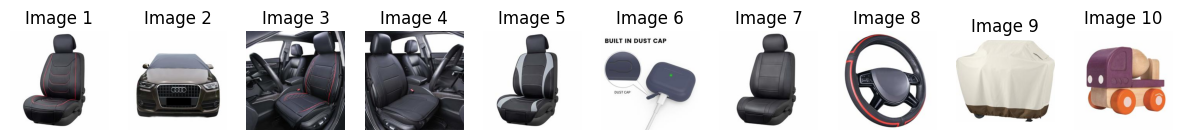




Searching for: computer




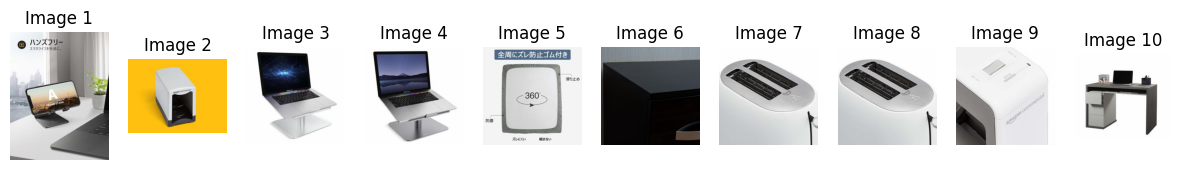




Searching for: cat




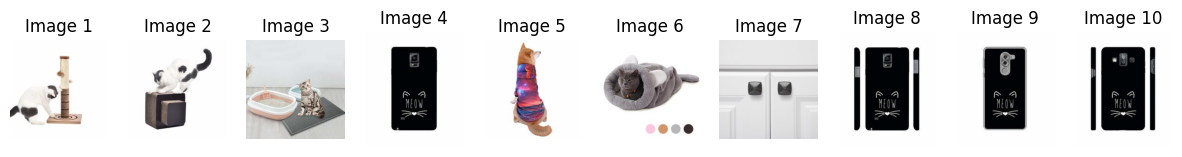




Searching for: dog




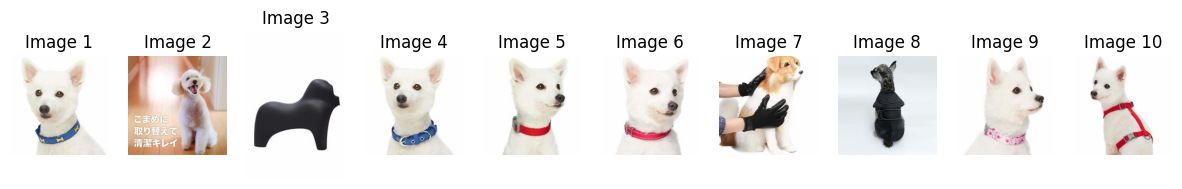




Searching for: math




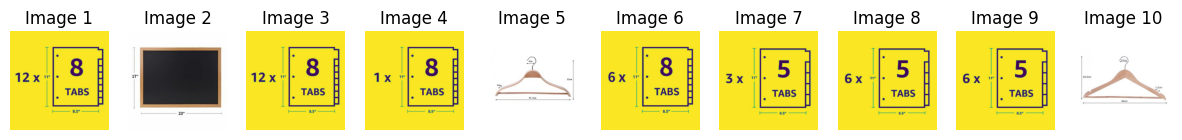




Searching for: ball




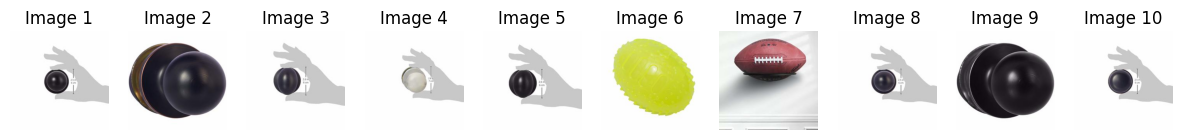




Searching for: football




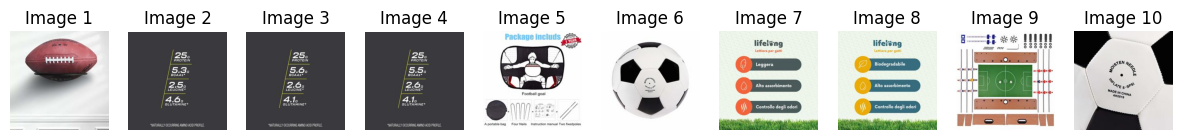

In [22]:
img_searcher = ImageSearch(engine, model)
test_results_relevancy(img_searcher, description_to_test, k=10)

Testing for MAX_IMAGES=150000

In [ ]:
MAX_IMAGES = 150000
# Dropping and creating the table again
# For production solution could be done better, e.g somehow filtering images
# That were already inserted but I believe  for laboratory purpose this is enough
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
vectorize_images(engine, model, image_paths)

  0%|          | 0/150000 [00:00<?, ?it/s]

Inserted 150000 images, stopping as MAX_IMAGES=150000 reached.


Testing for MAX_IMAGES=150000 images
Searching for: car




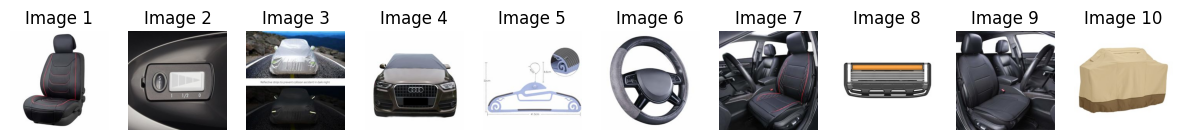




Searching for: computer




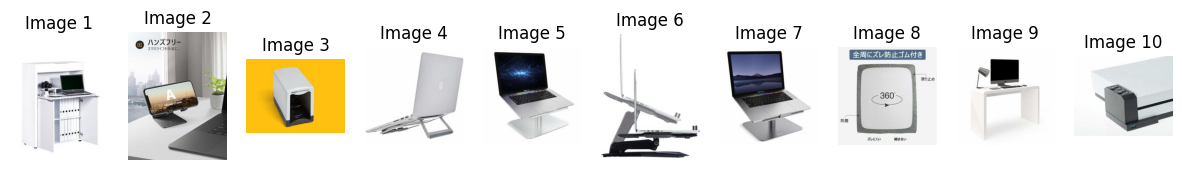




Searching for: cat




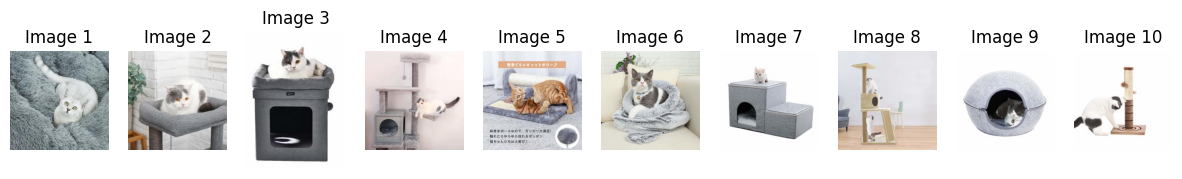




Searching for: dog




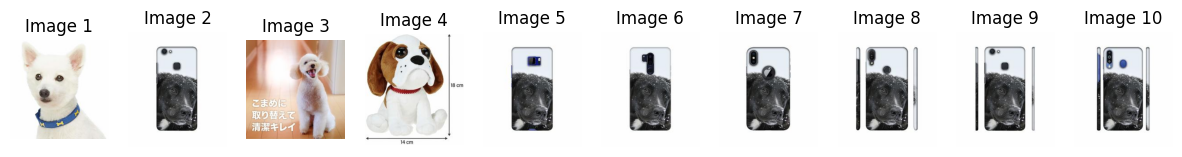




Searching for: math




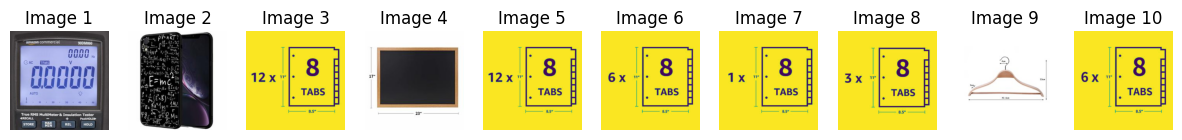




Searching for: ball




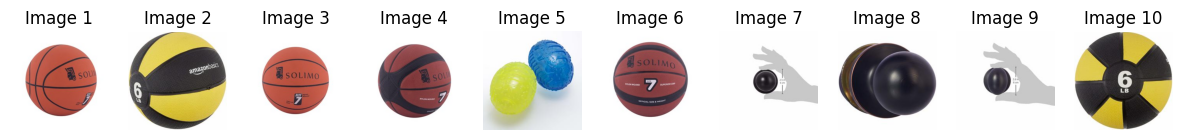




Searching for: football




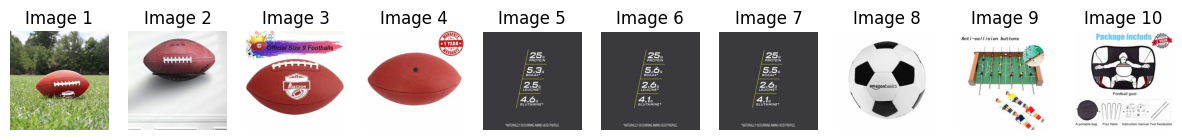

In [24]:
img_searcher = ImageSearch(engine, model)
test_results_relevancy(img_searcher, description_to_test, k=10)

Testing for MAX_IMAGES=342878 (all images after filtering)

In [25]:
MAX_IMAGES = len(image_paths)
# Dropping and creating the table again
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
vectorize_images(engine, model, image_paths)

  0%|          | 0/342878 [00:00<?, ?it/s]

Inserted 342878 images, stopping as MAX_IMAGES=342878 reached.


Testing for MAX_IMAGES=342878 images
Searching for: car




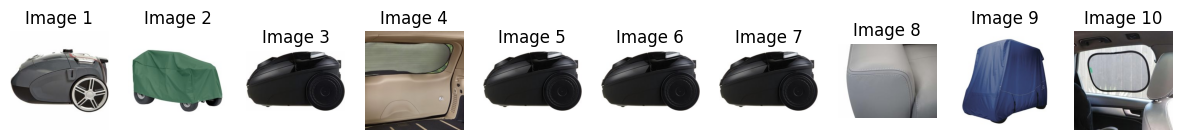




Searching for: computer




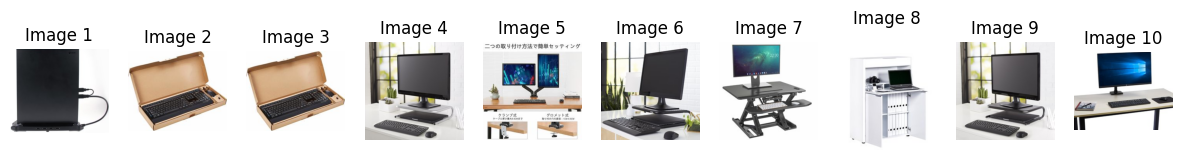




Searching for: cat




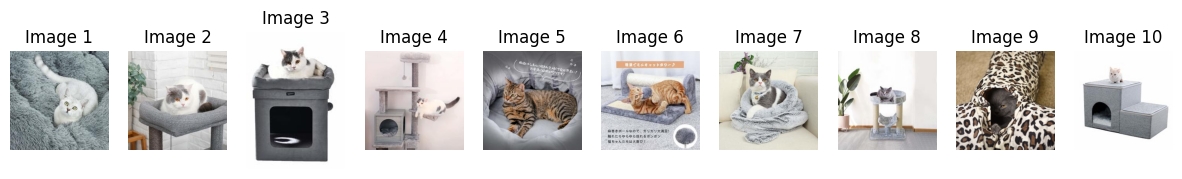




Searching for: dog




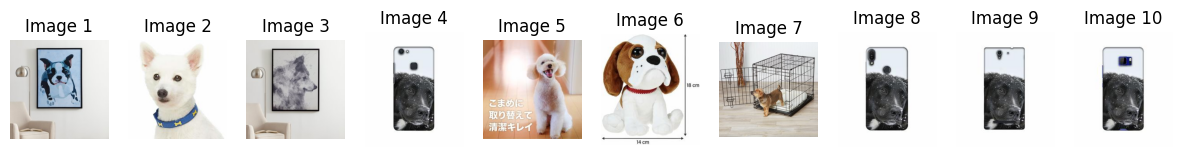




Searching for: math




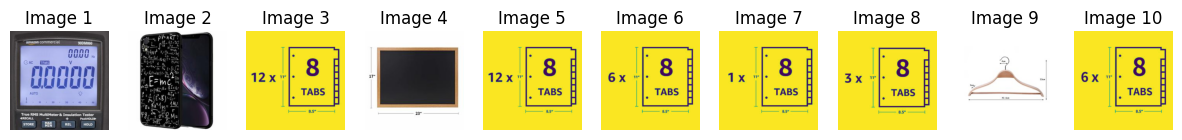




Searching for: ball




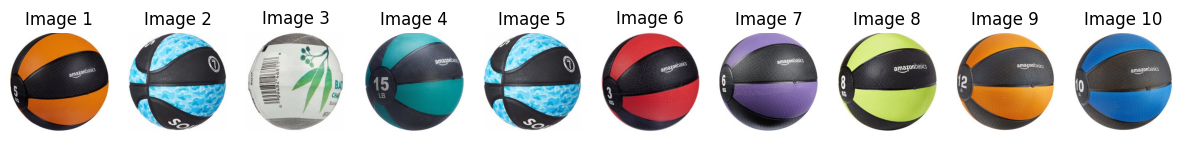




Searching for: football




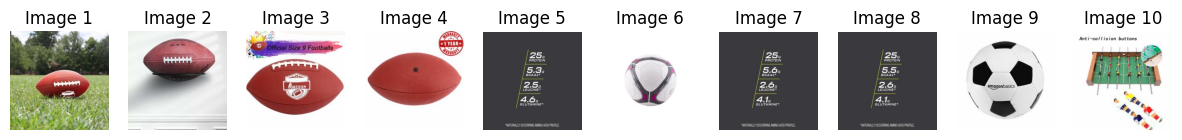

In [26]:
img_searcher = ImageSearch(engine, model)
test_results_relevancy(img_searcher, description_to_test, k=10)